# SAMPIC Timing Analysis

Comprehensive analysis of SAMPIC event and collector timing metrics.

In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import os

plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Paths
DATA_FILE = "../../output.root"
BUILD_LIB_PATH = "../../build/lib"

## Load Libraries and Data

In [2]:
# Load SAMPIC data product libraries
libs_to_load = [
    "libanalysis_pipeline_core.so",
    "libunpacker_data_products_core.so",
    "libunpacker_data_products_sampic.so",
]

for lib in libs_to_load:
    path = os.path.join(BUILD_LIB_PATH, lib)
    if os.path.exists(path):
        print(f"Loading {lib}...")
        ROOT.gSystem.Load(path)
    else:
        print(f"Warning: {lib} not found")

Loading libanalysis_pipeline_core.so...
Loading libunpacker_data_products_core.so...
Loading libunpacker_data_products_sampic.so...


In [3]:
# Open the ROOT file
f = ROOT.TFile.Open(DATA_FILE)
if not f or f.IsZombie():
    print(f"Error: Could not open file {DATA_FILE}")
else:
    tree = f.Get("events")
    print(f"Number of events in file: {tree.GetEntries()}")
    print("\nAvailable branches:")
    for branch in tree.GetListOfBranches():
        print(f"  - {branch.GetName()}")

    if tree.GetBranch("has_sampic_collector_timing"):
        print("\nBranch 'has_sampic_collector_timing' indicates whether the AC00 bank was present for each event.")


Number of events in file: 773352

Available branches:
  - sampic_event
  - sampic_event_timing
  - sampic_collector_timing
  - has_sampic_collector_timing

Branch 'has_sampic_collector_timing' indicates whether the AC00 bank was present for each event.


## Collect Event Timing Data

In [4]:
# Collect event timing data from many events
n_events = tree.GetEntries()

# Event timing arrays
et_prepare_max = []
et_read_max = []
et_decode_max = []
et_total_max = []
et_prepare_sum = []
et_read_sum = []
et_decode_sum = []
et_total_sum = []
et_nhits = []
et_nparents = []

# Collector timing arrays (only fill when AC00 bank present)
ct_wait = []
ct_group = []
ct_finalize = []
ct_total = []
ct_n_events = []
ct_total_hits = []
collector_present_flags = []

for i in range(n_events):
    tree.GetEntry(i)

    # Event timing (should always be present)
    et = getattr(tree, "sampic_event_timing", None)
    if et:
        et_prepare_max.append(et.sp_prepare_us_max)
        et_read_max.append(et.sp_read_us_max)
        et_decode_max.append(et.sp_decode_us_max)
        et_total_max.append(et.sp_total_us_max)
        et_prepare_sum.append(et.sp_prepare_us_sum)
        et_read_sum.append(et.sp_read_us_sum)
        et_decode_sum.append(et.sp_decode_us_sum)
        et_total_sum.append(et.sp_total_us_sum)
        et_nhits.append(et.nhits)
        et_nparents.append(et.nparents)
    else:
        collector_present_flags.append(False)
        continue

    has_collector = bool(getattr(tree, "has_sampic_collector_timing", False))
    collector_present_flags.append(has_collector)

    if has_collector:
        ct = getattr(tree, "sampic_collector_timing", None)
        if ct:
            ct_wait.append(ct.wait_us)
            ct_group.append(ct.group_build_us)
            ct_finalize.append(ct.finalize_us)
            ct_total.append(ct.total_us)
            ct_n_events.append(ct.n_events)
            ct_total_hits.append(ct.total_hits)

# Convert to numpy arrays
et_prepare_max = np.array(et_prepare_max)
et_read_max = np.array(et_read_max)
et_decode_max = np.array(et_decode_max)
et_total_max = np.array(et_total_max)
et_prepare_sum = np.array(et_prepare_sum)
et_read_sum = np.array(et_read_sum)
et_decode_sum = np.array(et_decode_sum)
et_total_sum = np.array(et_total_sum)
et_nhits = np.array(et_nhits)
et_nparents = np.array(et_nparents)

collector_presence = np.array(collector_present_flags, dtype=bool)
ct_wait = np.array(ct_wait)
ct_group = np.array(ct_group)
ct_finalize = np.array(ct_finalize)
ct_total = np.array(ct_total)
ct_n_events = np.array(ct_n_events)
ct_total_hits = np.array(ct_total_hits)

collector_fraction = (collector_presence.mean() * 100.0) if collector_presence.size else 0.0
present_count = int(collector_presence.sum()) if collector_presence.size else 0

print()
print(f"Collected timing data from {n_events} events")
print(f"Event timing entries: {len(et_total_max)}")
print(f"Collector timing entries: {present_count} ({collector_fraction:.1f}% of events)")



Collected timing data from 773352 events
Event timing entries: 773352
Collector timing entries: 20 (0.0% of events)


## Event Timing Distributions

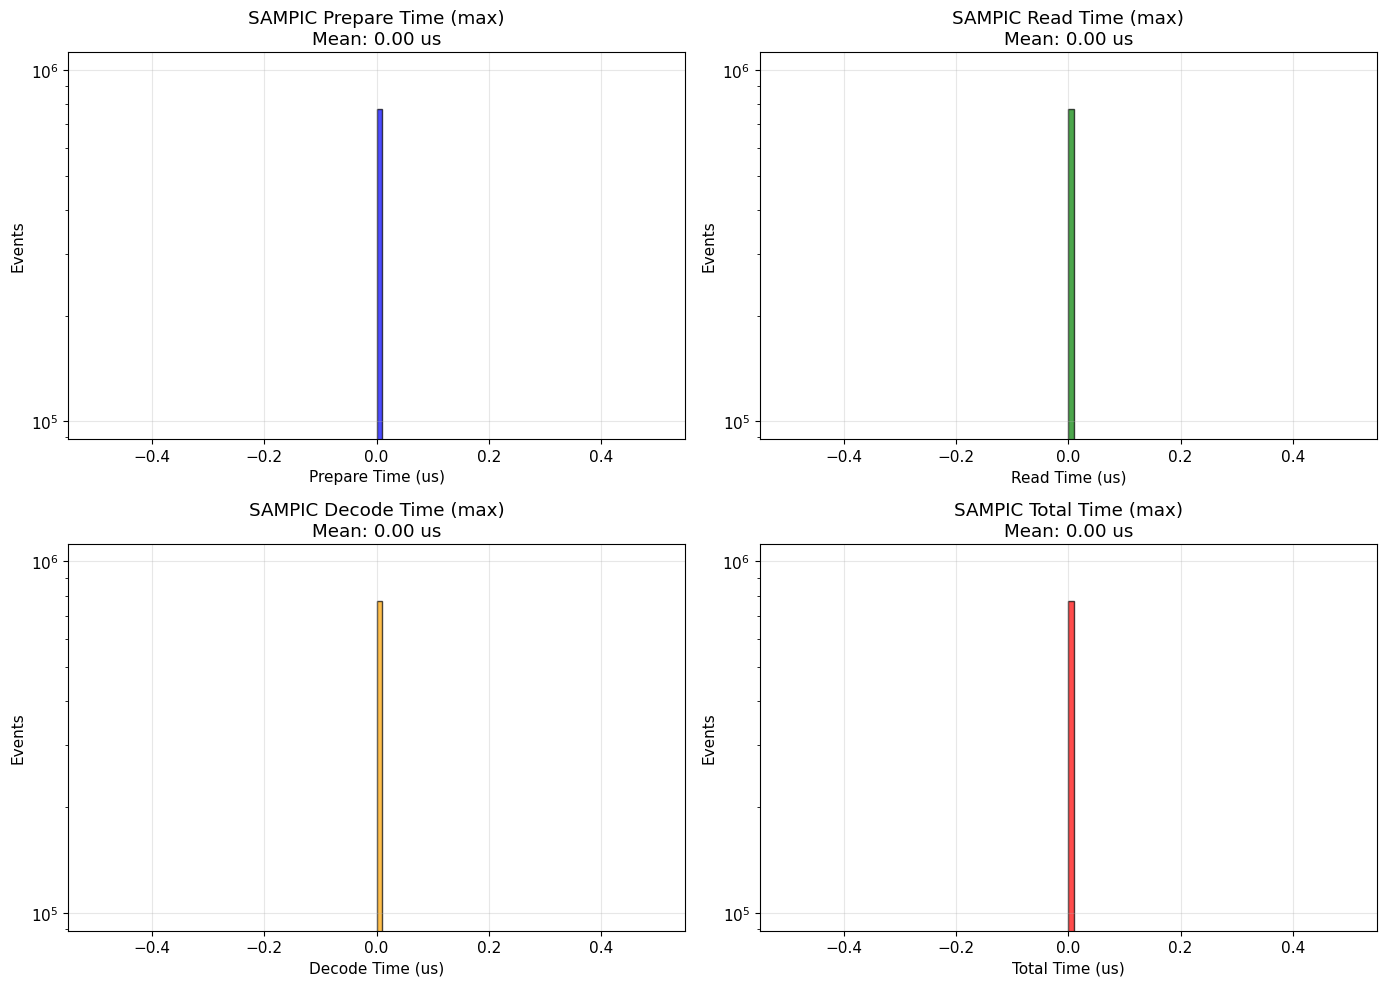

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Prepare time
axes[0, 0].hist(et_prepare_max, bins=100, alpha=0.7, edgecolor='black', color='blue')
axes[0, 0].set_xlabel('Prepare Time (us)')
axes[0, 0].set_ylabel('Events')
axes[0, 0].set_title(f'SAMPIC Prepare Time (max)\nMean: {np.mean(et_prepare_max):.2f} us')
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True, alpha=0.3)

# Read time
axes[0, 1].hist(et_read_max, bins=100, alpha=0.7, edgecolor='black', color='green')
axes[0, 1].set_xlabel('Read Time (us)')
axes[0, 1].set_ylabel('Events')
axes[0, 1].set_title(f'SAMPIC Read Time (max)\nMean: {np.mean(et_read_max):.2f} us')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

# Decode time
axes[1, 0].hist(et_decode_max, bins=100, alpha=0.7, edgecolor='black', color='orange')
axes[1, 0].set_xlabel('Decode Time (us)')
axes[1, 0].set_ylabel('Events')
axes[1, 0].set_title(f'SAMPIC Decode Time (max)\nMean: {np.mean(et_decode_max):.2f} us')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Total time
axes[1, 1].hist(et_total_max, bins=100, alpha=0.7, edgecolor='black', color='red')
axes[1, 1].set_xlabel('Total Time (us)')
axes[1, 1].set_ylabel('Events')
axes[1, 1].set_title(f'SAMPIC Total Time (max)\nMean: {np.mean(et_total_max):.2f} us')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Collector Timing Analysis (when available)

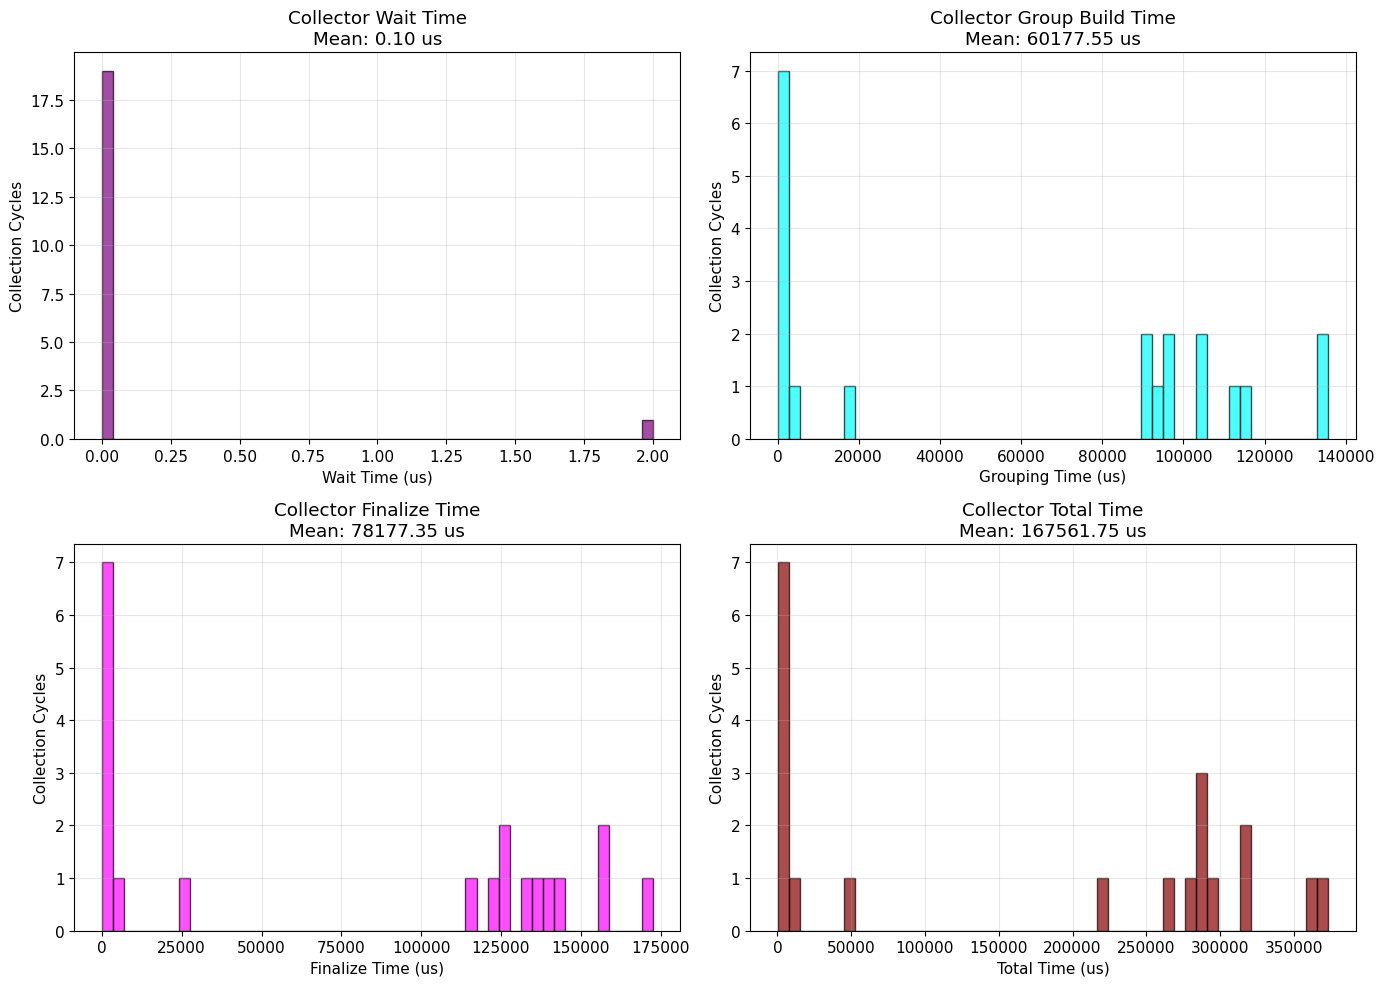

In [6]:
if len(ct_total) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Wait time
    axes[0, 0].hist(ct_wait, bins=50, alpha=0.7, edgecolor='black', color='purple')
    axes[0, 0].set_xlabel('Wait Time (us)')
    axes[0, 0].set_ylabel('Collection Cycles')
    axes[0, 0].set_title(f'Collector Wait Time\nMean: {np.mean(ct_wait):.2f} us')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Group time
    axes[0, 1].hist(ct_group, bins=50, alpha=0.7, edgecolor='black', color='cyan')
    axes[0, 1].set_xlabel('Grouping Time (us)')
    axes[0, 1].set_ylabel('Collection Cycles')
    axes[0, 1].set_title(f'Collector Group Build Time\nMean: {np.mean(ct_group):.2f} us')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Finalize time
    axes[1, 0].hist(ct_finalize, bins=50, alpha=0.7, edgecolor='black', color='magenta')
    axes[1, 0].set_xlabel('Finalize Time (us)')
    axes[1, 0].set_ylabel('Collection Cycles')
    axes[1, 0].set_title(f'Collector Finalize Time\nMean: {np.mean(ct_finalize):.2f} us')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Total time
    axes[1, 1].hist(ct_total, bins=50, alpha=0.7, edgecolor='black', color='darkred')
    axes[1, 1].set_xlabel('Total Time (us)')
    axes[1, 1].set_ylabel('Collection Cycles')
    axes[1, 1].set_title(f'Collector Total Time\nMean: {np.mean(ct_total):.2f} us')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No collector timing data available in this dataset")

## Timing vs Event Size

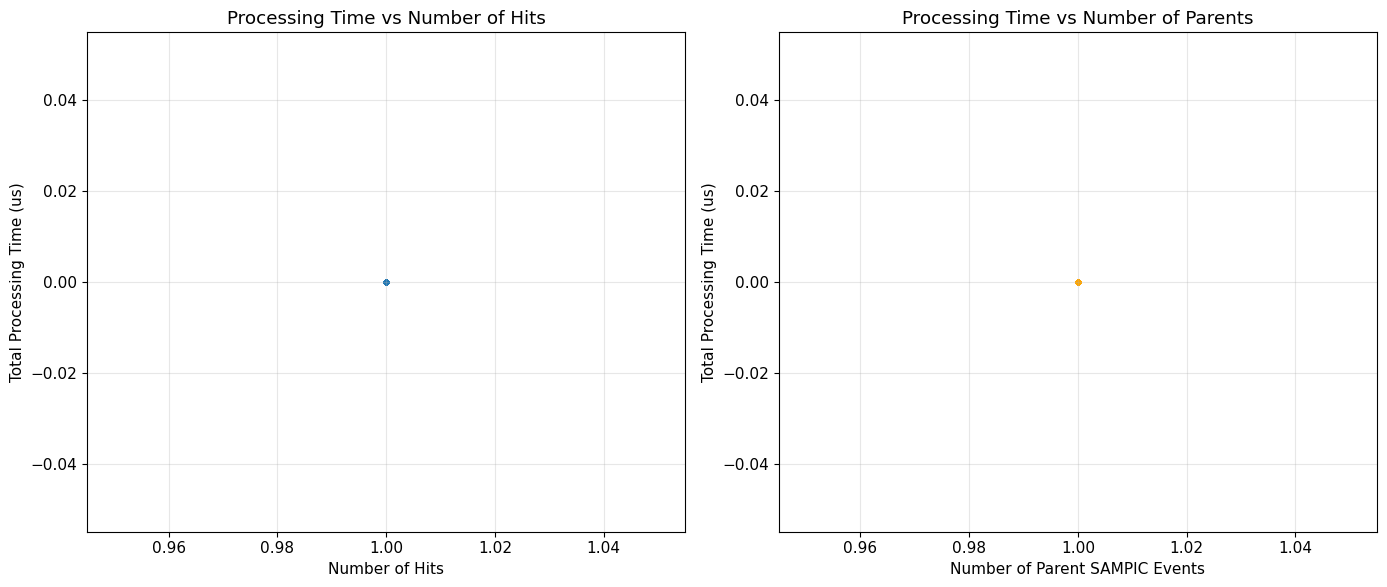

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Total time vs number of hits
axes[0].scatter(et_nhits, et_total_max, alpha=0.3, s=10)
axes[0].set_xlabel('Number of Hits')
axes[0].set_ylabel('Total Processing Time (us)')
axes[0].set_title('Processing Time vs Number of Hits')
axes[0].grid(True, alpha=0.3)

# Total time vs number of parent events
axes[1].scatter(et_nparents, et_total_max, alpha=0.3, s=10, color='orange')
axes[1].set_xlabel('Number of Parent SAMPIC Events')
axes[1].set_ylabel('Total Processing Time (us)')
axes[1].set_title('Processing Time vs Number of Parents')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary Statistics

In [8]:
print("=" * 60)
print("EVENT TIMING STATISTICS (microseconds)")
print("=" * 60)
print(f"{'Phase':<15} {'Mean':>10} {'Std':>10} {'Min':>10} {'Max':>10}")
print("-" * 60)
print(f"{'Prepare':<15} {np.mean(et_prepare_max):>10.2f} {np.std(et_prepare_max):>10.2f} {np.min(et_prepare_max):>10.2f} {np.max(et_prepare_max):>10.2f}")
print(f"{'Read':<15} {np.mean(et_read_max):>10.2f} {np.std(et_read_max):>10.2f} {np.min(et_read_max):>10.2f} {np.max(et_read_max):>10.2f}")
print(f"{'Decode':<15} {np.mean(et_decode_max):>10.2f} {np.std(et_decode_max):>10.2f} {np.min(et_decode_max):>10.2f} {np.max(et_decode_max):>10.2f}")
print(f"{'Total':<15} {np.mean(et_total_max):>10.2f} {np.std(et_total_max):>10.2f} {np.min(et_total_max):>10.2f} {np.max(et_total_max):>10.2f}")
print("=" * 60)

if len(ct_total) > 0:
    print()
    print("=" * 60)
    print("COLLECTOR TIMING STATISTICS (microseconds)")
    print("=" * 60)
    print(f"{'Phase':<15} {'Mean':>10} {'Std':>10} {'Min':>10} {'Max':>10}")
    print("-" * 60)
    print(f"{'Wait':<15} {np.mean(ct_wait):>10.2f} {np.std(ct_wait):>10.2f} {np.min(ct_wait):>10.2f} {np.max(ct_wait):>10.2f}")
    print(f"{'Group':<15} {np.mean(ct_group):>10.2f} {np.std(ct_group):>10.2f} {np.min(ct_group):>10.2f} {np.max(ct_group):>10.2f}")
    print(f"{'Finalize':<15} {np.mean(ct_finalize):>10.2f} {np.std(ct_finalize):>10.2f} {np.min(ct_finalize):>10.2f} {np.max(ct_finalize):>10.2f}")
    print(f"{'Total':<15} {np.mean(ct_total):>10.2f} {np.std(ct_total):>10.2f} {np.min(ct_total):>10.2f} {np.max(ct_total):>10.2f}")
    print("=" * 60)
    print()
    print(f"Collector cycles present: {present_count} ({collector_fraction:.2f}% of events)")
    print(f"Average events per cycle: {np.mean(ct_n_events):.1f}")
    print(f"Average hits per cycle: {np.mean(ct_total_hits):.1f}")


EVENT TIMING STATISTICS (microseconds)
Phase                 Mean        Std        Min        Max
------------------------------------------------------------
Prepare               0.00       0.00       0.00       0.00
Read                  0.00       0.00       0.00       0.00
Decode                0.00       0.00       0.00       0.00
Total                 0.00       0.00       0.00       0.00

COLLECTOR TIMING STATISTICS (microseconds)
Phase                 Mean        Std        Min        Max
------------------------------------------------------------
Wait                  0.10       0.44       0.00       2.00
Group             60177.55   53361.29      11.00  135689.00
Finalize          78177.35   68771.34      20.00  172559.00
Total            167561.75  149104.65      42.00  373440.00

Collector cycles present: 20 (0.00% of events)
Average events per cycle: 36979.8
Average hits per cycle: 36979.8
